In [1]:
import torch.nn as nn

class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        # Add size check
        # If the spatial sizes of x and skip_input don’t match, resizes x to match skip_input
        if x.size(2) != skip_input.size(2) or x.size(3) != skip_input.size(3):
            x = F.interpolate(x, size=(skip_input.size(2), skip_input.size(3)))
        return torch.cat((x, skip_input), 1)

In [2]:
class Pix2PixGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.down1 = UNetDown(1, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512)
        self.down5 = UNetDown(512, 512)
        self.down6 = UNetDown(512, 512)

        # Decoder
        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 256, dropout=0.5)
        self.up4 = UNetUp(512, 128)
        self.up5 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, 3, 4, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)

        # Decoder
        u1 = self.up1(d6, d5)
        u2 = self.up2(u1, d4)
        u3 = self.up3(u2, d3)
        u4 = self.up4(u3, d2)
        u5 = self.up5(u4, d1)

        return self.final(u5)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #  input channels 4 (3 for real/fake image + 1 for mask)
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, padding=1)
            # Reducing the feature map depth to 1 channel, producing a single scalar output for each patch.
            # The discriminator evaluates each patch individually, as opposed to the entire image, making it a PatchGAN discriminator.
        )

    def forward(self, img_A, img_B):
        # img_A is the generated/real image (3 channels)
        # img_B is the mask (1 channel)
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [3]:
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class RoadSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, transform=None, is_test=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.is_test = is_test

        if is_test:
            # For test set, look for images in subdirectories
            self.images = []
            for test_dir in sorted(os.listdir(image_dir)):
                dir_path = os.path.join(image_dir, test_dir)
                if os.path.isdir(dir_path):
                    for img in os.listdir(dir_path):
                        if img.endswith(('.png', '.jpg', '.jpeg')):
                            self.images.append(os.path.join(test_dir, img))
        else:
            self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        image = image.resize((416, 416))  # Resize to 416x416

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, self.images[idx]  # Return image name for test set
        else:
            mask_path = os.path.join(self.mask_dir, self.images[idx])
            mask = Image.open(mask_path).convert('L')
            mask = mask.resize((416, 416))  # Resize to 416x416
            mask = transforms.ToTensor()(mask)
            mask = (mask > 0.5).float()
            return image, mask

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
# Create training and validation datasets
train_val_dataset = RoadSegmentationDataset(
    image_dir="/content/drive/MyDrive/images",
    mask_dir="/content/drive/MyDrive/groundtruth",
    transform=transform
)

# Create test dataset
test_dataset = RoadSegmentationDataset(
    image_dir="/content/drive/MyDrive/test_set_images",
    transform=transform,
    is_test=True
)

In [5]:
from torch.utils.data import DataLoader

# Use all data for training the GAN (no split needed since we have separate test dataset)
train_loader = DataLoader(train_val_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print(f"Training samples: {len(train_val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 100
Test samples: 50


In [15]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
class RoadSegmentationGAN:
    def __init__(self):
        self.generator = Pix2PixGenerator().to(device)
        self.discriminator = Discriminator().to(device)
        self.criterion_GAN = nn.MSELoss()
        self.criterion_pixelwise = nn.L1Loss()
        self.lambda_pixel = 50

        # Directory for saving models
        self.model_dir = "saved_models"
        os.makedirs(self.model_dir, exist_ok=True)

    def train_gan(self, train_loader, num_epochs=3000):
        optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
        optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

        for epoch in range(num_epochs):
            epoch_d_loss = 0
            epoch_g_loss = 0
            num_batches = 0

            for i, (real_images, real_masks) in enumerate(train_loader):
                batch_size = real_images.size(0)
                real_images = real_images.to(device)
                real_masks = real_masks.to(device)

                if real_masks.dim() == 3:
                    real_masks = real_masks.unsqueeze(1)

                # Train Discriminator
                optimizer_D.zero_grad()
                fake_images = self.generator(real_masks)
                pred_fake = self.discriminator(fake_images.detach(), real_masks)
                loss_D_fake = self.criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
                pred_real = self.discriminator(real_images, real_masks)
                loss_D_real = self.criterion_GAN(pred_real, torch.ones_like(pred_real))
                loss_D = (loss_D_fake + loss_D_real) * 0.5
                loss_D.backward()
                optimizer_D.step()

                # Train Generator
                optimizer_G.zero_grad()
                pred_fake = self.discriminator(fake_images, real_masks)
                loss_G_GAN = self.criterion_GAN(pred_fake, torch.ones_like(pred_fake))
                loss_G_L1 = self.criterion_pixelwise(fake_images, real_images) * self.lambda_pixel
                loss_G = loss_G_GAN + loss_G_L1
                loss_G.backward()
                optimizer_G.step()

                epoch_d_loss += loss_D.item()
                epoch_g_loss += loss_G.item()
                num_batches += 1

            # Calculate average losses
            avg_d_loss = epoch_d_loss / num_batches
            avg_g_loss = epoch_g_loss / num_batches

            # Print losses every epoch
            print(f"Epoch [{epoch+1}/{num_epochs}] D loss: {avg_d_loss:.4f} G loss: {avg_g_loss:.4f}")

            # Generate a sample every 50 epochs
            if (epoch + 1) % 50 == 0:
                self.generate_sample(fake_images, real_images, real_masks, epoch + 1)

            # Save models every 300 epochs
            if (epoch + 1) % 300 == 0:
                self.save_models(epoch + 1)

    def save_models(self, epoch):
        """Save the generator and discriminator models."""
        generator_path = os.path.join(self.model_dir, f"generator_epoch_{epoch}.pth")
        discriminator_path = os.path.join(self.model_dir, f"discriminator_epoch_{epoch}.pth")

        torch.save(self.generator.state_dict(), generator_path)
        torch.save(self.discriminator.state_dict(), discriminator_path)
        print(f"Saved models at epoch {epoch}:")
        print(f"  Generator saved to: {generator_path}")
        print(f"  Discriminator saved to: {discriminator_path}")

    def generate_sample(self, fake_images, real_images, real_masks, epoch):
        """Generate and display a sample image using matplotlib."""
        # Convert tensors to numpy arrays
        fake_image = fake_images[0].detach().cpu().numpy().transpose(1, 2, 0)
        real_image = real_images[0].detach().cpu().numpy().transpose(1, 2, 0)
        real_mask = real_masks[0].detach().cpu().numpy().squeeze()

        # Normalize the images for display
        fake_image = (fake_image * 0.5 + 0.5)  # Normalize to [0, 1]
        real_image = (real_image * 0.5 + 0.5)  # Normalize to [0, 1]

        # Plot the images
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'Sample at Epoch {epoch}', fontsize=16)

        # Fake image
        plt.subplot(1, 3, 1)
        plt.imshow(fake_image)
        plt.axis("off")
        plt.title("Fake Image")

        # Real image
        plt.subplot(1, 3, 2)
        plt.imshow(real_image)
        plt.axis("off")
        plt.title("Real Image")

        # Real mask
        plt.subplot(1, 3, 3)
        plt.imshow(real_mask, cmap="gray")
        plt.axis("off")
        plt.title("Real Mask")

        # Show the plot
        plt.show()

    def load_models(self, epoch):
        """Load the generator and discriminator models from saved files."""
        generator_path = f"/content/drive/MyDrive/generator_epoch_900.pth"
        discriminator_path = f"/content/drive/MyDrive/discriminator_epoch_900.pth"

        self.generator.load_state_dict(torch.load(generator_path))
        self.discriminator.load_state_dict(torch.load(discriminator_path))

        print(f"Loaded models from epoch {epoch}:")
        print(f"  Generator loaded from: {generator_path}")
        print(f"  Discriminator loaded from: {discriminator_path}")


In [10]:
import torch

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the selected device
print(f"Using device: {device}")

Using device: cuda


In [16]:
# Initialize GAN
gan = RoadSegmentationGAN()

# Load models
start_epoch = 900
gan.load_models(start_epoch)

# Reinitialize optimizers
optimizer_G = torch.optim.Adam(gan.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(gan.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Resume training
print("Resuming Pix2Pix GAN training...")
gan.train_gan(train_loader, num_epochs=3000 - start_epoch)

Output hidden; open in https://colab.research.google.com to view.

In [22]:
# Generate new samples using the trained GAN
def generate_new_samples(gan_model, train_loader, num_samples=10):
    gan_model.generator.eval()
    new_images = []
    new_masks = []
    samples_generated = 0

    with torch.no_grad():
        while samples_generated < num_samples:
            for _, masks in train_loader:
                if samples_generated >= num_samples:
                    break

                # Ensure masks have correct shape
                if masks.dim() == 3:
                    masks = masks.unsqueeze(1)
                masks = masks.to(device)

                # Generate fake images
                fake_images = gan_model.generator(masks)

                new_images.append(fake_images.cpu())
                new_masks.append(masks.cpu())

                samples_generated += masks.size(0)

    # Concatenate all generated samples
    new_images = torch.cat(new_images[:num_samples], dim=0)
    new_masks = torch.cat(new_masks[:num_samples], dim=0)

    return new_images, new_masks

print("Generating new samples...")
new_images, new_masks = generate_new_samples(gan, train_loader)
print(f"Generated {len(new_images)} new samples")

# the extra 3 generated images comes from that the
# train_loader has a batch size of 4, and we've already generated 998 samples,
# the next batch will add 4 more samples, bringing the total to 1002 or 1003 (depending on the exact batch size).
# doesnt effect that much


Generating new samples...
Generated 12 new samples


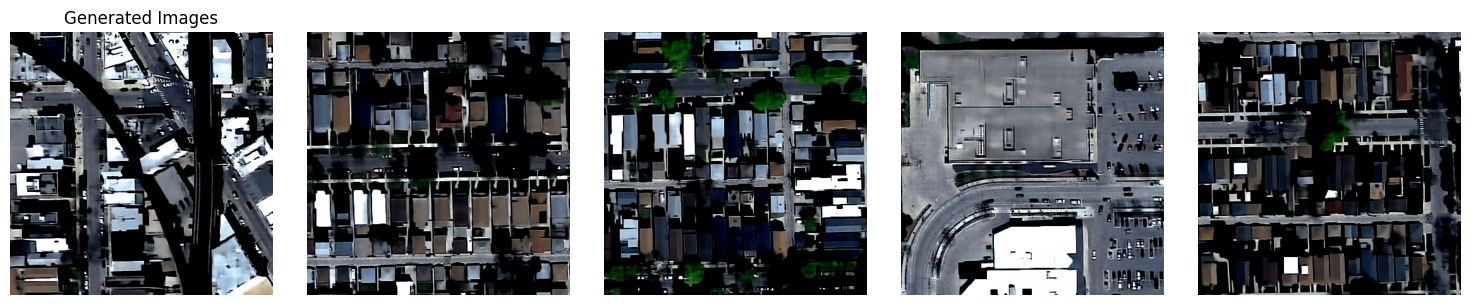

In [23]:
import numpy as np
def visualize_generated_samples(generator, dataset, num_samples=5, figsize=(15, 3)):
    """
    Visualize only the generated images from the GAN

    """
    generator.eval()  # Set generator to evaluation mode
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    with torch.no_grad():
        for i in range(num_samples):
            idx = np.random.randint(len(dataset))
            _, mask = dataset[idx]

            # Ensure mask has correct dimensions
            if mask.dim() == 3:
                mask = mask.unsqueeze(0)
            else:
                mask = mask.unsqueeze(0).unsqueeze(0)

            # Generate image
            mask = mask.to(device)
            generated_image = generator(mask)

            # Convert to numpy and adjust format
            gen_img = generated_image.cpu().squeeze(0).numpy()
            gen_img = np.transpose(gen_img, (1, 2, 0))
            # Denormalize
            gen_img = (gen_img * 0.5 + 0.5).clip(0, 1)

            # Display
            axes[i].imshow(gen_img)
            axes[i].axis('off')
            if i == 0:
                axes[i].set_title('Generated Images')

    plt.tight_layout()
    plt.show()

visualize_generated_samples(gan.generator, train_val_dataset)

In [25]:
def save_generated_samples(new_images, new_masks, images_dir, masks_dir, target_size=None):
    """
    Save generated images and masks into separate folders with proper denormalization and resizing.

    Parameters:
        new_images (torch.Tensor): Generated images tensor (N, C, H, W).
        new_masks (torch.Tensor): Corresponding masks tensor (N, C, H, W).
        images_dir (str): Full path to the folder where images will be saved.
        masks_dir (str): Full path to the folder where masks will be saved.
        target_size (tuple): Target size (H, W) for resizing images and masks.
    """
    # Create directories if they do not exist
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(masks_dir, exist_ok=True)

    # Resize images and masks if target size is specified
    if target_size is not None:
        new_images = F.interpolate(new_images, size=target_size, mode='bilinear', align_corners=False)
        new_masks = F.interpolate(new_masks, size=target_size, mode='nearest')  # For binary masks

    # Denormalize images
    new_images = (new_images * 0.5 + 0.5).clamp(0, 1)

    # Save each image and mask
    for i in range(new_images.size(0)):
        image_path = os.path.join(images_dir, f'image_{i:04d}.png')
        mask_path = os.path.join(masks_dir, f'mask_{i:04d}.png')

        save_image(new_images[i], image_path)
        save_image(new_masks[i], mask_path)

    print(f"Saved {new_images.size(0)} images in {images_dir} and masks in {masks_dir}.")


In [26]:
# Full paths for saving images and masks
images_directory = '/content/drive/MyDrive/generated_samples/generated_images/'
masks_directory = '/content/drive/MyDrive/generated_samples/generated_masks/'

# Save the generated samples
save_generated_samples(new_images, new_masks, images_directory, masks_directory)

Saved 12 images in /content/drive/MyDrive/generated_samples/generated_images/ and masks in /content/drive/MyDrive/generated_samples/generated_masks/.
